100%|██████████| 344862509/344862509 [00:12<00:00, 26861536.47it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 554819.66it/s]


100%|██████████| 14989/14989 [00:00<00:00, 12741877.31it/s]


==>> gt: 100 <<===
==>> img   <<===


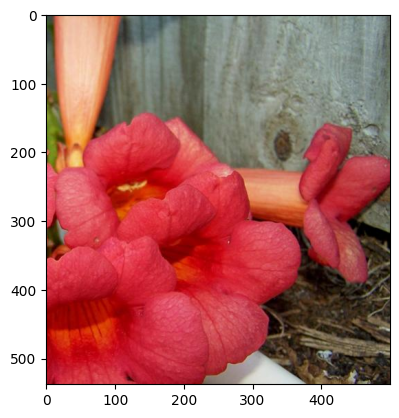

In [ ]:

import torch
from torchvision.datasets import Flowers102
from torchvision import transforms as T
from matplotlib import pyplot as plt

# A
ds = Flowers102(root ='data', download=True)


# B
item = ds[1000]
img, gt = item

print(f"==>> gt: {gt} <<===")
print(f"==>> img   <<===")
plt.imshow(img, cmap = "gray")


In [ ]:

ts_tfs = T.Compose([
    T.Resize((32,32)),
    T.ToTensor(),
    T.Normalize(mean=0.5, std=0.5)
])
ds = Flowers102(root='data', download=True,transform=ts_tfs)

In [ ]:

from torch.utils.data import random_split, DataLoader

data_size = len(ds)

tr_size = int(data_size*0.8)
vl_size = int(data_size*0.1)
ts_size = int(data_size*0.1)

tr_ds, vl_ds, ts_ds = random_split(ds, [tr_size,vl_size,ts_size])
print(f"==>> tr_ds: {len(tr_ds)}")
print(f"==>> vl_ds: {len(vl_ds)}")
print(f"==>> ts_ds: {len(ts_ds)}")


==>> tr_ds: 816
==>> vl_ds: 102
==>> ts_ds: 102


In [ ]:

bs = 256

tr_dl = DataLoader(dataset=tr_ds, batch_size=bs, num_workers=8, shuffle=True)
vl_dl = DataLoader(dataset=vl_ds, batch_size=bs, num_workers=8, shuffle=False)
ts_dl = DataLoader(dataset=ts_ds, batch_size=bs, num_workers=8, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
from torch.nn import *
class CustomModel(Module):
    def __init__(self, in_chs, out_chs, ks, s, p, in_fs, n_cls = 102):
        super().__init__()

        # Conv Block N1
        self.conv_1 = Conv2d(in_channels = in_chs, out_channels = out_chs, kernel_size = ks, stride = s, padding = p)
        self.act = ReLU()
        self.mp = MaxPool2d(kernel_size = 2, stride = 2)

        # Conv Block N2
        self.conv_2 = Conv2d(in_channels = out_chs, out_channels = out_chs * 2, kernel_size = ks, stride = s, padding = p)

        # Conv Block N3
        self.conv_3 = Conv2d(in_channels = out_chs * 2, out_channels = out_chs * 4, kernel_size = ks, stride = s, padding = p)

        # Conv Block N4
        self.conv_4 = Conv2d(in_channels = out_chs * 4, out_channels = out_chs * 8, kernel_size = ks, stride = s, padding = p)

        # Linear Layers N1
        self.linear_1 = Linear(in_features = in_fs, out_features = in_fs // 2)

        # Linear Layers N2
        self.linear_2 = Linear(in_features = in_fs // 2, out_features = n_cls)
    def forward(self, inp):
        # Conv Block N1
        out = self.conv_1(inp)
        out = self.act(out)
        out = self.mp(out)
        # Conv Block N2
        out = self.conv_2(out)
        out = self.act(out)
        out = self.mp(out)
        # Conv Block N3
        out = self.conv_3(out)
        out = self.act(out)
        out = self.mp(out)
        # Conv Block N4
        out = self.conv_4(out)
        out = self.act(out)
        out = self.mp(out)

        # print("Shape before flattening:", out.shape)
        bs = out.shape[0]
        out = out.view(bs, -1) # 4D -> 2D

        # Linear Layers N1
        out = self.act(self.linear_1(out))
        # Linear Layers N2
        out = self.linear_2(out)

        return out


model = CustomModel(in_chs = 3, out_chs = 8, ks = 3, s = 1, p = 1, in_fs = 256)


In [ ]:

loss_fn = CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-4)
device='cude' if torch.cuda.is_available() else 'cpu'
epochs = 20

model.to(device)

CustomModel(
  (conv_1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act): ReLU()
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear_1): Linear(in_features=256, out_features=128, bias=True)
  (linear_2): Linear(in_features=128, out_features=102, bias=True)
)

In [ ]:
for epoch in range(epochs):
    model.train()
    print(f"==>> Starting Epoch: {epoch+1}")
    epoch_loss, epoch_acc = 0, 0

    for idx, batch in enumerate(tr_dl):
        imgs, gts = batch
        imgs, gts = imgs.to(device), gts.to(device)

        pred_results = model(imgs)

        loss = loss_fn(pred_results, gts)
        predictions = torch.argmax(pred_results, dim=1)
        match = (predictions==gts).sum()

        epoch_loss += loss.item()
        epoch_acc += match.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("".center(50, "-"))
    print(f"{epoch + 1}-epoch training loss       -> {(epoch_loss / len(tr_dl)):.3f}")
    print(f"{epoch + 1}-epoch training acc        -> {(epoch_acc / len(tr_dl.dataset)):.3f}")

    model.eval()

    with torch.no_grad():
        val_epoch_loss, val_epoch_acc = 0, 0

        for idx, batch in enumerate(vl_dl):
            # if idx == 1: break
            imgs, gts = batch
            imgs, gts = imgs.to(device), gts.to(device)
            pred_results = model(imgs)

            loss = loss_fn(pred_results, gts)
            predictions = torch.argmax(pred_results, dim=1)
            match = (predictions==gts).sum()

            val_epoch_loss += loss.item()
            val_epoch_acc  += match.item()
        print("".center(50, "-"))
        print(f"{epoch + 1}-epoch validation loss       -> {(val_epoch_loss / len(vl_dl)):.3f}")
        print(f"{epoch + 1}-epoch validation acc        -> {(val_epoch_acc / len(vl_dl.dataset)):.3f}")


==>> Starting Epoch: 1
--------------------------------------------------
1-epoch training loss       -> 4.628
1-epoch training acc        -> 0.007
--------------------------------------------------
1-epoch validation loss       -> 4.628
1-epoch validation acc        -> 0.000
==>> Starting Epoch: 2
--------------------------------------------------
2-epoch training loss       -> 4.626
2-epoch training acc        -> 0.013
--------------------------------------------------
2-epoch validation loss       -> 4.629
2-epoch validation acc        -> 0.000
==>> Starting Epoch: 3
--------------------------------------------------
3-epoch training loss       -> 4.626
3-epoch training acc        -> 0.016
--------------------------------------------------
3-epoch validation loss       -> 4.629
3-epoch validation acc        -> 0.020
==>> Starting Epoch: 4
--------------------------------------------------
4-epoch training loss       -> 4.623
4-epoch training acc        -> 0.013
---------------------

In [ ]:
rasmlar, javoblar = next(iter(ts_dl))
print(rasmlar.shape)
print(javoblar.shape)
hamma_bashoratlar, hamma_rasmlar, hamma_javoblar = [], [], []

torch.Size([102, 3, 32, 32])
torch.Size([102])


In [ ]:
for idx, (rasm, javob) in enumerate(zip(rasmlar, javoblar)):
    # if idx == 1: break
    rasm, javob = rasm.to(device), javob.to(device)
    rasm = rasm.unsqueeze(dim = 0)
    bashorat =  model(rasm)
    bashorat_javob = torch.argmax(bashorat, dim = 1).item()
    hamma_bashoratlar.append(bashorat_javob); hamma_rasmlar.append(rasm), hamma_javoblar.append(javob)

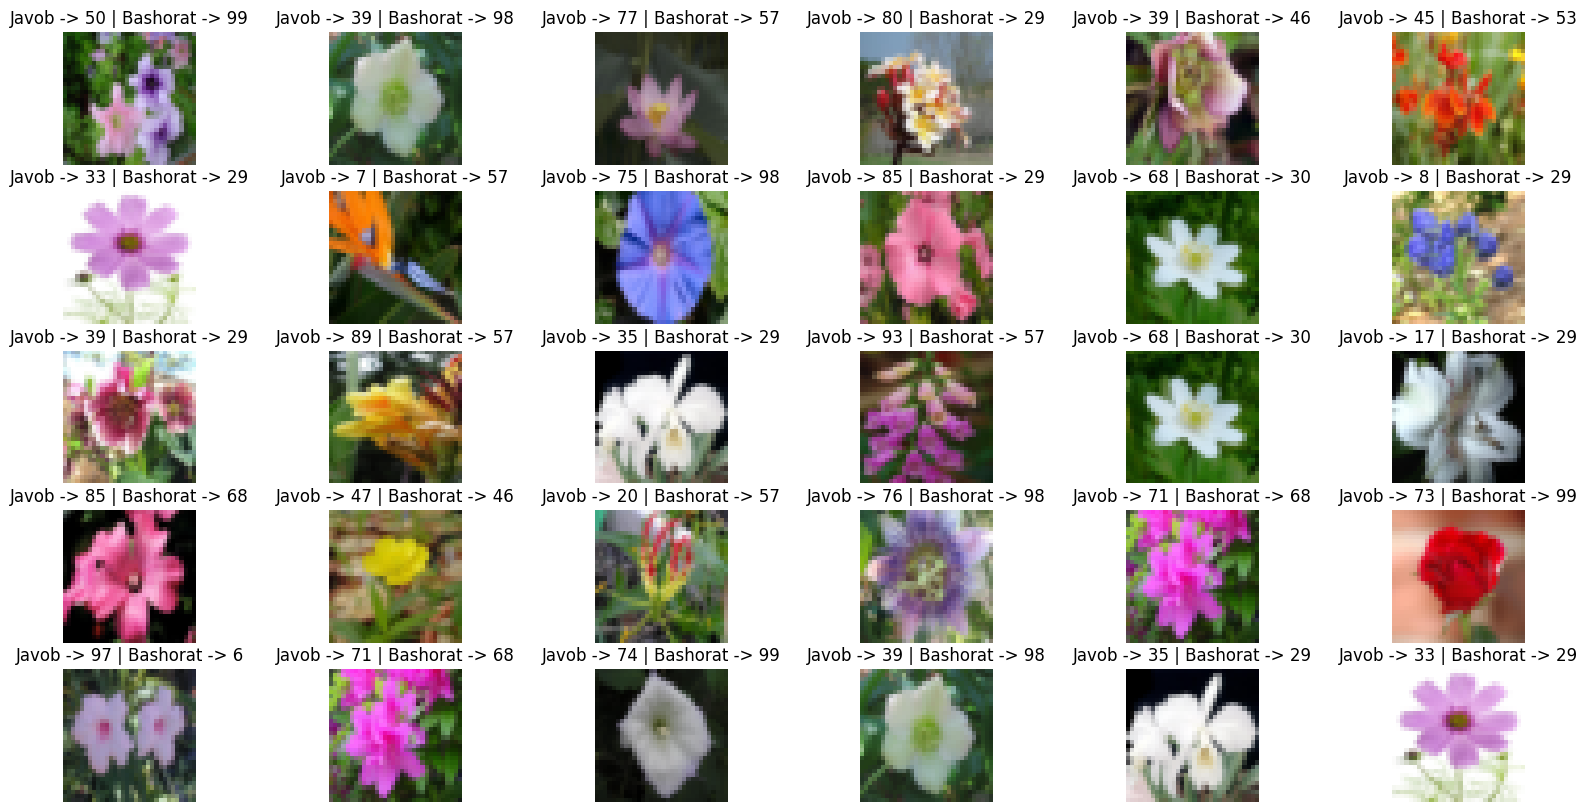

In [ ]:
import random
from matplotlib import pyplot as plt

rasmlar_soni, qatorlar_soni = 30, 5

plt.figure(figsize=(20, 10))
indekslar = [random.randint(a=0, b=len(hamma_rasmlar) - 1) for _ in range(rasmlar_soni)]

for idx, indeks in enumerate(indekslar):
    rasm = hamma_rasmlar[indeks]
    javob = hamma_javoblar[indeks]
    bashorat = hamma_bashoratlar[indeks]

    # Handle batch dimension if present
    if rasm.dim() == 4:
        rasm = rasm.squeeze(0)

    # Denormalize the image tensor
    rasm = rasm * 0.5 + 0.5  # Denormalize

    plt.subplot(qatorlar_soni, rasmlar_soni // qatorlar_soni, idx + 1)
    plt.axis("off")
    # Convert tensor to numpy array and scale to [0, 255] range
    plt.imshow((rasm.permute(1, 2, 0).cpu().numpy() * 255).astype("uint8"))
    plt.title(f"Javob -> {javob} | Bashorat -> {bashorat}")

plt.show()
